# StyleDNA

This is the quick infencing code for styleDNA.



## Download Models and pretrained models

In [ ]:
!git clone https://github.com/aiiu-lab/StyleDNA.git

Cloning into 'StyleDNA'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 86 (delta 30), reused 37 (delta 5), pack-reused 3
Unpacking objects: 100% (86/86), done.


In [ ]:
#!pip install gdown
!gdown https://drive.google.com/u/0/uc?id=1cFC5j8PyZYwy5pAW5AZDBDqvSnh31SsA&export=download
!gdown https://drive.google.com/u/0/uc?id=1doaaGITOk9TMK_cPsJhqWim7j0exZRpc&export=download
!gdown https://drive.google.com/u/0/uc?id=1orcyIN79yk2VvDQ0mtdr7FP_64DKcOWo&export=download
!gdown https://drive.google.com/u/0/uc?id=1UKZ68Hhu8OqAzOEmhqTieWVxnf8CsdHf&export=download
!gdown https://drive.google.com/u/0/uc?id=1p4K_fMSUpTsRqW_EefFH72u3Mxw5BDrb&export=download
!gdown https://drive.google.com/u/0/uc?id=1WkzDLVe5O5lo_hV7AVBzJ41RuDEMnDQb&export=download
!gdown https://drive.google.com/u/0/uc?id=1AmXuxJ-qrtBW4YVUWzVf5Y4ZxLNC65cq&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1cFC5j8PyZYwy5pAW5AZDBDqvSnh31SsA
To: /content/enc_4_2.pth
100% 164M/164M [00:01<00:00, 129MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1doaaGITOk9TMK_cPsJhqWim7j0exZRpc
To: /content/condi_4_2.pth
100% 10.1M/10.1M [00:00<00:00, 88.7MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1orcyIN79yk2VvDQ0mtdr7FP_64DKcOWo
To: /content/60.pth
100% 6.35M/6.35M [00:00<00:00, 54.8MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1UKZ68Hhu8OqAzOEmhqTieWVxnf8CsdHf
To: /content/stylegan2-ffhq-config-f.pt
100% 381M/381M [00:02<00:00, 141MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1p4K_fMSUpTsRqW_EefFH72u3Mxw5BDrb
To: /content/shape_predictor_68_face_landmarks.dat
100% 99.7M/99.7M [00:00<00:00, 130MB/s] 
Downloading...
From: https://drive.google.com/u/0/uc?id=1WkzDLVe5O5lo_hV7AVBzJ41RuDEMnDQb
To: /content/mom.png
100% 78.6k/78.6k [00:00<00:00, 28.6MB/s]
Downloading...
From: https://drive.g

## Import packages


In [ ]:
!pip install ninja
!pip install dlib
!pip install -q gwpy

     |████████████████████████████████| 108 kB 5.6 MB/s 
     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 51 kB 5.9 MB/s 
     |████████████████████████████████| 11.2 MB 34.8 MB/s 
     |████████████████████████████████| 890 kB 41.5 MB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 3.6 MB 26.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
%%capture
import torch
import os
import numpy as np
import PIL
import sys
import glob
import scipy
import dlib
from torchvision.utils import save_image
import torch.nn as nn
from torchvision import transforms

# Takes some time (about 1 min) to build 
%cd StyleDNA
from model.model import pSp, condi
from model.DNAnet import DNAnet
%cd ../

In [ ]:
%%capture
device = torch.device("cuda")
DNA = DNAnet().to(device)
DNA.load_state_dict(torch.load('./60.pth'), strict=True)
DNA.eval()

net = nn.DataParallel(pSp(3, './enc_4_2.pth', './stylegan2-ffhq-config-f.pt')).to(device)
net.eval()

mapper = nn.DataParallel(condi()).to(device)
mapper.load_state_dict(torch.load('./condi_4_2.pth'), strict=True)
mapper.eval()

In [ ]:
#@title utils

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)   

predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

def totensor(img):
    img = transform(img)    
    
    return img

def get_landmark(filepath):
    """get landmark with dlib
    :return: np.array shape=(68, 2)
    """
    detector = dlib.get_frontal_face_detector()

    img = dlib.load_rgb_image(filepath)
    dets = detector(img, 1)

    #print("Number of faces detected: {}".format(len(dets)))
    for k, d in enumerate(dets):
        #print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
        #    k, d.left(), d.top(), d.right(), d.bottom()))
        # Get the landmarks/parts for the face in box d.
        shape = predictor(img, d)
        #print("Part 0: {}, Part 1: {} ...".format(shape.part(0), shape.part(1)))


    t = list(shape.parts())
    a = []
    for tt in t:
        a.append([tt.x, tt.y])
    lm = np.array(a)
    # lm is a shape=(68,2) np.array
    return lm

    
def align_face(filepath):
    """
    :param filepath: str
    :return: PIL Image
    """

    lm = get_landmark(filepath)
    
    lm_chin          = lm[0  : 17]  # left-right
    lm_eyebrow_left  = lm[17 : 22]  # left-right
    lm_eyebrow_right = lm[22 : 27]  # left-right
    lm_nose          = lm[27 : 31]  # top-down
    lm_nostrils      = lm[31 : 36]  # top-down
    lm_eye_left      = lm[36 : 42]  # left-clockwise
    lm_eye_right     = lm[42 : 48]  # left-clockwise
    lm_mouth_outer   = lm[48 : 60]  # left-clockwise
    lm_mouth_inner   = lm[60 : 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left     = np.mean(lm_eye_left, axis=0)
    eye_right    = np.mean(lm_eye_right, axis=0)
    eye_avg      = (eye_left + eye_right) * 0.5
    eye_to_eye   = eye_right - eye_left
    mouth_left   = lm_mouth_outer[0]
    mouth_right  = lm_mouth_outer[6]
    mouth_avg    = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2


    # read image
    img = PIL.Image.open(filepath)

    output_size=256
    transform_size=4096
    enable_padding=False

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, PIL.Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    if output_size < transform_size:
        img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

    # Save aligned image.
    return img


## Inferencing

In [ ]:
# Set Parameters
mom_path = './mom.png'
dad_path = './dad.png'
target_age = 25
target_gender = 'female'

In [ ]:
mImg = align_face(mom_path).convert('RGB')
dImg = align_face(dad_path).convert('RGB')
testAge =  torch.ones((1,1)) * int(target_age) /100 
if target_gender == 'male':
  testGen = torch.ones(1, 1).to(device)
elif target_gender == 'female':
  testGen = torch.zeros(1, 1).to(device)
else:
  print("wrong setting of gender")

In [ ]:
with torch.no_grad():
  mImg_t = totensor(mImg).unsqueeze(0).to(device)
  dImg_t = totensor(dImg).unsqueeze(0).to(device)

  sW_hat = DNA(net.module.encoder(mImg_t), net.module.encoder(dImg_t))
  sW_hat_expand = sW_hat.repeat(18, 1, 1).permute(1, 0, 2)
  sW_hat_delta = mapper(sW_hat_expand, testAge, testGen)
  sImg_hat = net(sW_hat_expand + sW_hat_delta)

  save_image((sImg_hat+1)/2, f'./result.png', nrow = 1)    

## Visualizing

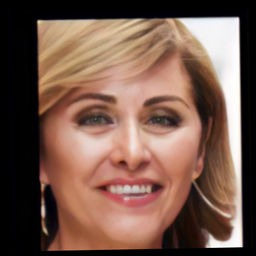

In [ ]:
mImg

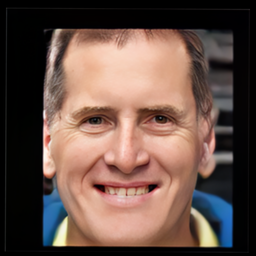

In [ ]:
dImg

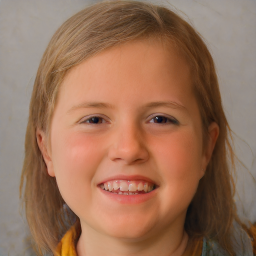

In [ ]:
child = PIL.Image.open("./result.png")
child